In [7]:
# Standard Library Imports
import os
import sys
from importlib import reload
from functools import partial
from enum import Enum
from typing import NamedTuple
from time import sleep
from glob import glob
import re

# Third-Party Library Imports
import numpy as np
from numpy.typing import ArrayLike
import pandas as pd
import xarray as xr
from scipy.stats import spearmanr

# Plotting imports
import hvplot.xarray
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker as mticker
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import seaborn as sns
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# My imports
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'time_of_emergene_drafts'))
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'time_of_emergene_drafts', 'src'))

import utils
import plotting_utils
import climate_utils
import stats
import time_of_emrgence_calc as toe
import toe_constants as toe_const
import open_data
from toe_constants import PVALUE_THESHOLD1, OVERLAP_THRESHOLD, SN_THRESHOLD1
import time_of_emergence_plots
import toe_constants as toe_const
import plotting_utils
import constants
import os
# Suppress Warnings
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', message="p-value floored: true value smaller than 0.001")
warnings.filterwarnings('ignore', message="p-value capped: true value larger than 0.25")

Matplotlib created a temporary config/cache directory at /jobfs/122371046.gadi-pbs/matplotlib-3y4rne4_ because the default path (/home/563/ab2313/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Matplotlib is building the font cache; this may take a moment.


In [ ]:
# walltime = '00:10:00'
# cores = 48
# memory = str(cores * 4) + 'GB'

# cluster = PBSCluster(walltime=str(walltime), cores=cores, memory=str(memory), processes=cores,
#                      job_extra_directives=['-q normal',
#                                            '-P w42',
#                                            '-l ncpus='+str(cores),
#                                            '-l mem='+str(memory),
#                                            '-l storage=gdata/w42+gdata/rt52'],
#                      local_directory='$TMPDIR',
#                      job_directives_skip=["select"])
# cluster.scale(jobs=1)
# client = Client(cluster)

In [1]:
# client.close()

In [2]:
from dask.distributed import Client
client = Client(threads_per_worker=1, n_workers=8)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 8
Total threads: 8,Total memory: 251.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35779,Workers: 8
Dashboard: /proxy/8787/status,Total threads: 8
Started: Just now,Total memory: 251.19 GiB
Comm: tcp://127.0.0.1:40557,Total threads: 1
Dashboard: /proxy/44279/status,Memory: 31.40 GiB
Nanny: tcp://127.0.0.1:33747,


2024-08-06 13:42:23,513 - distributed.protocol.core - CRITICAL - Failed to Serialize
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/protocol/core.py", line 109, in dumps
    frames[0] = msgpack.dumps(msg, default=_encode_default, use_bin_type=True)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/msgpack/__init__.py", line 36, in packb
    return Packer(**kwargs).pack(o)
  File "msgpack/_packer.pyx", line 294, in msgpack._cmsgpack.Packer.pack
  File "msgpack/_packer.pyx", line 300, in msgpack._cmsgpack.Packer.pack
  File "msgpack/_packer.pyx", line 297, in msgpack._cmsgpack.Packer.pack
  File "msgpack/_packer.pyx", line 264, in msgpack._cmsgpack.Packer._pack
  File "msgpack/_packer.pyx", line 231, in msgpack._cmsgpack.Packer._pack
  File "msgpack/_packer.pyx", line 264, in msgpack._cmsgpack.Packer._pack
  File "msgpack/_packer.pyx", line 202, in msgpa

In [5]:
MMLEA_DIR = '/g/data/v45/nxm561'
model = 'gfdl_spear_lens'
variable = 'tas'
model_name_in_file = 'GFDL-SPEAR-MED'

In [8]:
path_string = os.path.join(MMLEA_DIR, model, 'Amon', variable, f'{variable}_{model_name_in_file}_*.nc')
path_string

'/g/data/v45/nxm561/gfdl_spear_lens/Amon/tas/tas_GFDL-SPEAR-MED_*.nc'

In [9]:
file_paths = glob(path_string)
file_paths[:3]

['/g/data/v45/nxm561/gfdl_spear_lens/Amon/tas/tas_GFDL-SPEAR-MED_hist_ssp585_r16i1p1f1_192101-210012.nc',
 '/g/data/v45/nxm561/gfdl_spear_lens/Amon/tas/tas_GFDL-SPEAR-MED_hist_ssp585_r28i1p1f1_192101-210012.nc',
 '/g/data/v45/nxm561/gfdl_spear_lens/Amon/tas/tas_GFDL-SPEAR-MED_hist_ssp585_r11i1p1f1_192101-210012.nc']

In [10]:
len(file_paths)

30

In [11]:
ensemble_members = [re.search(r'_(r\d+i\d+p\d+f\d+)', file).group(1) for file in file_paths]
ensemble_members[:3]

['r16i1p1f1', 'r28i1p1f1', 'r11i1p1f1']

In [12]:
dataset_list = [xr.open_dataset(file).tas for file in file_paths]

In [13]:
datasets_with_ensemble = [ds.expand_dims(ensemble=[em]) for ds, em in zip(dataset_list, ensemble_members)]

In [14]:
combined_raw_ds = xr.concat(datasets_with_ensemble, dim='ensemble')

In [15]:
chunk_size = {'ensemble':-1, 'time':-1, 'lon':12, 'lat':18}

In [16]:
combined_raw_ds = combined_raw_ds.chunk(chunk_size)

In [17]:
combined_ds = combined_raw_ds.resample(time='y').mean()

In [18]:
combined_ds

<xarray.DataArray 'tas' (ensemble: 30, time: 180, lat: 72, lon: 144)> Size: 448MB
dask.array<transpose, shape=(30, 180, 72, 144), dtype=float64, chunksize=(30, 180, 18, 12), chunktype=numpy.ndarray>
Coordinates:
  * ensemble  (ensemble) object 240B 'r16i1p1f1' 'r28i1p1f1' ... 'r12i1p1f1'
  * lon       (lon) float64 1kB 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * lat       (lat) float64 576B -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * time      (time) datetime64[ns] 1kB 1921-12-31 1922-12-31 ... 2100-12-31
Attributes:
    standard_name:  air_temperature
    long_name:      Near-Surface Air Temperature
    units:          K
    cell_methods:   time: mean
    interp_method:  conserve_order2
    cell_measures:  area: areacella

In [19]:
SAVE_PATH = '/g/data/w40/ab2313/time_of_emergence/large_ensembles/gfdl_spear_lens'

In [27]:
combined_ds

<xarray.DataArray 'tas' (ensemble: 30, time: 180, lat: 72, lon: 144)> Size: 448MB
dask.array<transpose, shape=(30, 180, 72, 144), dtype=float64, chunksize=(30, 180, 18, 12), chunktype=numpy.ndarray>
Coordinates:
  * ensemble  (ensemble) object 240B 'r16i1p1f1' 'r28i1p1f1' ... 'r12i1p1f1'
  * lon       (lon) float64 1kB 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * lat       (lat) float64 576B -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * time      (time) datetime64[ns] 1kB 1921-12-31 1922-12-31 ... 2100-12-31
Attributes:
    standard_name:  air_temperature
    long_name:      Near-Surface Air Temperature
    units:          K
    cell_methods:   time: mean
    interp_method:  conserve_order2
    cell_measures:  area: areacella

In [22]:
# Note 
encoding = {combined_ds.name:{'chunks':tuple(chunk_size[c] for c in list(combined_ds.coords))}}
encoding

{'tas': {'chunks': (-1, 12, 18, -1)}}

In [31]:
# client.close()

In [32]:
combined_ds.to_zarr(os.path.join(SAVE_PATH, 'tas_GFDL-SPEAR-MED_hist_ssp585_192101-210012_v3.zarr'),
                    mode='w')#, encoding=encoding)

In [36]:
combined_ds

<xarray.DataArray 'tas' (ensemble: 30, time: 180, lat: 72, lon: 144)> Size: 448MB
dask.array<transpose, shape=(30, 180, 72, 144), dtype=float64, chunksize=(30, 180, 18, 12), chunktype=numpy.ndarray>
Coordinates:
  * ensemble  (ensemble) object 240B 'r16i1p1f1' 'r28i1p1f1' ... 'r12i1p1f1'
  * lon       (lon) float64 1kB 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * lat       (lat) float64 576B -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * time      (time) datetime64[ns] 1kB 1921-12-31 1922-12-31 ... 2100-12-31
Attributes:
    standard_name:  air_temperature
    long_name:      Near-Surface Air Temperature
    units:          K
    cell_methods:   time: mean
    interp_method:  conserve_order2
    cell_measures:  area: areacella

In [34]:
# Test that it opens
test_open_ds = xr.open_zarr(os.path.join(SAVE_PATH, 'tas_GFDL-SPEAR-MED_hist_ssp585_192101-210012_v3.zarr'))

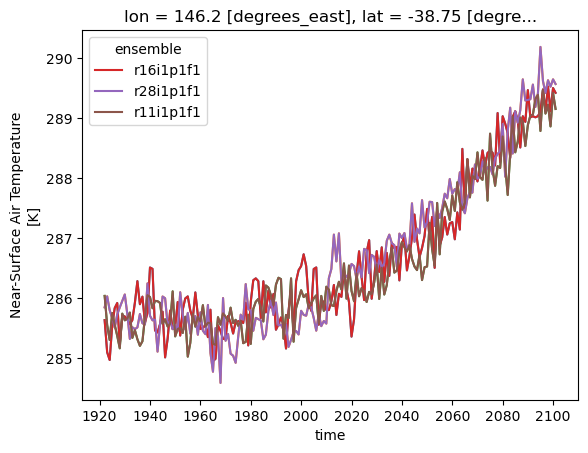

In [52]:
test_open_ds.sel(lat=-38, lon=145, method='nearest').isel(ensemble=slice(0,3)).tas.plot(hue='ensemble');
combined_ds.sel(lat=-38, lon=145, method='nearest').isel(ensemble=slice(0,3)).plot(hue='ensemble');

# Sample Single File Open

In [61]:
path = '/g/data/v45/nxm561/gfdl_spear_lens/Amon/tas/tas_GFDL-SPEAR-MED_hist_ssp585_r9i1p1f1_192101-210012.nc'
ds = xr.open_dataset(path)['tas']

In [64]:
ds

<xarray.DataArray 'tas' (time: 180, lat: 72, lon: 144)> Size: 15MB
array([[[224.5677503 , 224.48866908, 224.39380137, ..., 224.88174184,
         224.77584712, 224.67108027],
        [225.42691294, 225.11727015, 224.90652084, ..., 226.65907288,
         226.15719096, 225.74998474],
        [227.65310796, 226.79923121, 226.01907094, ..., 230.09300613,
         229.2615598 , 228.45712026],
        ...,
        [256.26436234, 256.37248611, 256.41794459, ..., 255.71569951,
         255.92843374, 256.11054484],
        [255.30249278, 255.31860097, 255.31183497, ..., 255.16585032,
         255.23074722, 255.27735138],
        [254.68743896, 254.69392268, 254.69742203, ..., 254.65509033,
         254.6659139 , 254.67671967]],

       [[225.46833547, 225.38554637, 225.29895274, ..., 225.78698603,
         225.67959213, 225.57329814],
        [226.15244675, 225.88036728, 225.70054626, ..., 227.32536952,
         226.85219828, 226.46028646],
        [228.26240667, 227.45540237, 226.71688461, ..., 230.63009008,
         229.86852264, 229.08355204],
...
        [270.30843608, 270.51050059, 270.71432749, ..., 269.69648997,
         269.9046224 , 270.11138662],
        [269.64350891, 269.76831055, 269.89309184, ..., 269.26836395,
         269.39498901, 269.51823934],
        [269.22413127, 269.25674693, 269.29086812, ..., 269.119133  ,
         269.15432485, 269.18931071]],

       [[230.00183996, 229.90049108, 229.81241735, ..., 230.33187739,
         230.22087479, 230.11090215],
        [230.47016017, 230.19688924, 229.99152756, ..., 231.6343956 ,
         231.15789159, 230.76971054],
        [232.55216599, 231.79416656, 231.11427816, ..., 234.76014328,
         234.03882726, 233.30689621],
        ...,
        [269.33737818, 269.57193502, 269.83846664, ..., 268.79924011,
         268.96043015, 269.13786697],
        [269.12426758, 269.22961044, 269.33547465, ..., 268.81788762,
         268.91967138, 269.02077611],
        [268.96765645, 269.01220449, 269.05607224, ..., 268.84243393,
         268.88414764, 268.92589315]]])
Coordinates:
  * lon      (lon) float64 1kB 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * lat      (lat) float64 576B -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * time     (time) datetime64[ns] 1kB 1921-12-31 1922-12-31 ... 2100-12-31
Attributes:
    standard_name:  air_temperature
    long_name:      Near-Surface Air Temperature
    units:          K
    cell_methods:   time: mean
    interp_method:  conserve_order2
    cell_measures:  area: areacella

In [62]:
ds = ds.resample(time='y').mean()

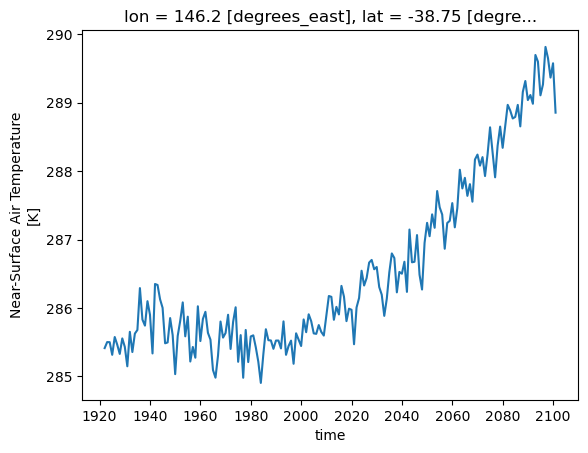

In [63]:
ds.sel(lat=-39, lon=146, method='nearest').plot()

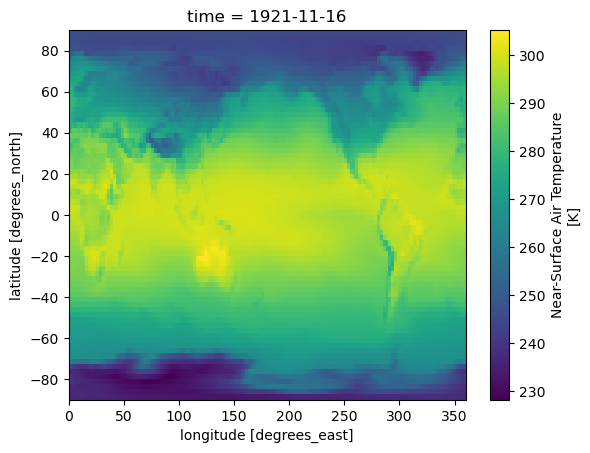

In [11]:
ds.isel(time=10).plot()

In [ ]:
os.listdier()